# How is US hazelnut production affected by inter-annual weather variation in the Willamette Valley of Oregon?

[Previous Notebook](cap2_NB01.ipynb)
# Notebook2
If you are viewing on Git, the links below may not work; for that or other issues try the [alternate render](https://nbviewer.jupyter.org/github/sbBEM/cap2/blob/master/notebooks/cap2_NB02.ipynb).

Table of contents
- [Importing](#Importing)
- [Cleaning(weather)](#Cleaning)
    - [Profiling](#Profiling)
    - [Data Defining](#DataDefining)
    - [Correcting Anomalies](#CorrectingAnomalies)
    - [Filling Empty Values](#FillingEmptyValues)
- [Exporting data](#Exportingdata)

[Next Notebook](cap2_NB03.ipynb)

- [Cleaning (crops)](cap2_NB03.ipynb#Cleaning)
- [Transforming](cap2_NB04.ipynb#Transforming)
- [Visualizing](cap2_NB04.ipynb#Visualizing)
- [Modeling](cap2_NB04.ipynb#Modeling)
- [Evaluating](cap2_NB04.ipynb#Evaluating)
- [Concluding](cap2_NB04.ipynb#Concluding)

The previous notebook focused on data collection. 
This notebook will focus on data definitions and cleaning of the weather data. 

## Importing <a name="Importing"></a>

Load python modules

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
#import google.cloud.bigquery as bq
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
#from io import BytesIO
#from zipfile import ZipFile
#import requests
#from IPython.core.display import display, HTML
#import tabula
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

Activate jupyter extentions

In [3]:
#%load_ext google.cloud.bigquery
%load_ext autoreload
%autoreload 2

Bring in the data from previous notebook.

In [4]:
weatherdf = pd.read_pickle("../data/raw/weather.pkl")
#our_stations = pd.read_pickle("../data/station.pkl")
#cropdf = pd.read_pickle("../data/crop.pkl")
#cropdf2 = pd.read_pickle("../data/crop2.pkl")
#region_points.read_pickle("../data/region.pkl")

## Cleaning <a name="Cleaning"></a>

### Profiling <a name="Profiling"></a>

In [5]:
weatherdf.describe()

,temp,count_temp,dewp,count_dewp,slp,count_slp,stp,count_stp,visib,count_visib,gust,max,min,prcp,sndp
count,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000,162928.000000
mean,53.074531,21.835713,540.537830,20.920321,3035.821540,16.526165,3878.491119,14.882930,48.371216,20.958061,760.179260,70.162080,53.833893,11.611211,996.703676
std,11.466504,4.951519,2167.568809,6.569140,3748.818994,9.770049,4242.002663,11.129757,182.885585,6.375431,420.693784,236.501388,320.639324,31.924838,56.379391
min,0.100000,4.000000,-10.700000,0.000000,981.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.900000,10.000000,-11.000000,0.000000,0.400000
25%,44.500000,24.000000,38.600000,23.000000,1015.300000,8.000000,1007.300000,0.000000,9.400000,23.000000,999.900000,53.100000,37.000000,0.000000,999.900000
50%,52.500000,24.000000,45.200000,24.000000,1019.800000,23.000000,1015.200000,24.000000,10.000000,24.000000,999.900000,63.000000,44.100000,0.000000,999.900000
75%,62.000000,24.000000,51.400000,24.000000,1029.800000,24.000000,9999.900000,24.000000,16.700000,24.000000,999.900000,75.900000,51.100000,0.150000,999.900000
max,97.900000,24.000000,9999.900000,24.000000,9999.900000,24.000000,9999.900000,24.000000,999.900000,24.000000,999.900000,9999.900000,9999.900000,99.990000,999.900000


We want to build data definitions to describe the features in the datasets to identify any issues that will require cleaning. We'll try the Pandas profiling module. 

In [6]:
weatherdfprofile = pandas_profiling.ProfileReport(weatherdf, title='Weatherdf Profiling Report', explorative=True)
#displays the report directly in the notebook: 
#weatherdfprofile.to_widgets()
#due to a notebook size problem, generate as a separate HTML report instead: 
weatherdfprofile.to_file("weatherdfprofile.html")

Summarize dataset:   0%|          | 0/48 [00:00<?, ?it/s]

/Users/bem/opt/anaconda3/envs/SB/lib/python3.9/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

[View Profile Report Here](weatherdfprofile.html)

The our_stations df was used in the previous notebook to narrow down the weather data and may not be needed again so we won't load it here. 

### Data Defining <a name="DataDefining"></a>
Data definitions for weather fields.

In [7]:
#Let's bring some organization to our list of fields which we're deciding what to do with. 
#We'll specify the value we see being used for missing values, whether we should drop the column, and what we should rename it to. 
wfields = { 
    'stn' : {'NewName' : 'StationID1', 'Drop?' : True, 'MissVal': '999999', 
        'Desc' : 'Only unique per station if combined with ID2.'},
    'wban' : {'NewName' : 'StationID2', 'Drop?' : True,  'MissVal': '99999', 
        'Desc' : 'Concat with ID1 to use but only needed if joining with stations table.'},
    'date' : {'NewName' : 'BadDate', 'Drop?' : True,
        'Desc' : 'We see this column is mostly empty and not useful.'},
    'year' : {'NewName' : 'Year', 'Drop?' : False, #Will drop later
        'Desc' : 'Year for this daily record at this station'},
    'mo' : {'NewName' : 'Month', 'Drop?' : False, #Will drop later
        'Desc' : 'Month of year for this daily record at this station'},
    'da' : {'NewName' : 'Day', 'Drop?' : False, #Will drop later
        'Desc' : 'Day of month for this daily record at this station'},
    'temp' : {'NewName' : 'Temperature', 'Drop?' : False, 'MissVal': 9999.9, 
        'Desc' : 'Mean of the hourly temperatures for 1 day by 1 station.'},
    'count_temp' : {'NewName' : 'TempCount', 'Drop?' : True,
        'Desc' : 'Number of temp readings for 1 day by 1 station.'},
    'dewp' : {'NewName' : 'Dewpoint', 'Drop?' : False, 'MissVal': 9999.9, 
        'Desc' : 'Related to humidity. Mean.'},
    'count_dewp' : {'NewName' : 'DewpCount', 'Drop?' : True,
        'Desc' : 'Number of dew readings for 1 day by 1 station.'},
    'slp' : {'NewName' : 'SeaPressure', 'Drop?' : True, 'MissVal': 9999.9, 
        'Desc' : 'Barometric pressure adjusted for elevation'},
    'count_slp' : {'NewName' : 'SeaCount', 'Drop?' : True,
        'Desc' : 'Number of sea readings for 1 day by 1 station.'},
    'stp' : {'NewName' : 'Pressure', 'Drop?' : False, 'MissVal': 9999.9, 
        'Desc' : 'Mean barometric pressure for 1 day by 1 station.'},
    'count_stp' : {'NewName' : 'PressureCount', 'Drop?' : True,
        'Desc' : 'Number of barometric readings for 1 day by 1 station'},
    'visib' : {'NewName' : 'Visibility', 'Drop?' : True, 'MissVal': 999.9, 
        'Desc' : 'Weather feature but we will assume has no effect.'},
    'count_visib' : {'NewName' : 'VisibilityCount', 'Drop?' : True,
        'Desc' : 'Number of visibility readings for 1 day by 1 station'},
    'wdsp' : {'NewName' : 'Wind', 'Drop?' : False, 'MissVal': '999.9', 
        'Desc' : 'Mean speed of wind for 1 day by 1 station'},
    'count_wdsp' : {'NewName' : 'WindCount', 'Drop?' : True,
        'Desc' : 'Number of wind readings for 1 day by 1 station'},
    'mxpsd' : {'NewName' : 'WindPeak', 'Drop?' : False, 'MissVal': '999.9', 
        'Desc' : 'Max wind that day excluding non-sustained gusts'},
    'gust' : {'NewName' : 'WindGust', 'Drop?' : False, 'MissVal': 999.9, 
        'Desc' : 'Highest wind speed that day'},
    'max' : {'NewName' : 'TempMax', 'Drop?' : False, 'MissVal': 9999.9, 
        'Desc' : 'maximum temperature that day at that station'},
    'flag_max' : {'NewName' : 'TempMaxFlag', 'Drop?' : True,
        'Desc' : 'indicates source of temperature max calculation'},
    'min' : {'NewName' : 'TempMin', 'Drop?' : False, 'MissVal': 9999.9, 
        'Desc' : 'minimum temperature that day at that station'},
    'flag_min' : {'NewName' : 'TempMinFlag', 'Drop?' : True,
        'Desc' : 'indicates source of temperature min calculation'},
    'prcp' : {'NewName' : 'Rain', 'Drop?' : False, 'MissVal': 99.99, 
        'Desc' : 'Rain and/or melted snow'},
    'flag_prcp' : {'NewName' : 'RainFlag', 'Drop?' : True,
        'Desc' : 'indicates source of rain calculation'},
    'sndp' : {'NewName' : 'Snow', 'Drop?' : False, 'MissVal': 999.9, 
        'Desc' : 'height of accumulated snow on ground'},
    'fog' : {'NewName' : 'FogBool', 'Drop?' : True,
        'Desc' : '1=True that some that day'},
    'rain_drizzle' : {'NewName' : 'DrizzleBool', 'Drop?' : True,
        'Desc' : '1=True that some fell that day'},
    'snow_ice_pellets' : {'NewName' : 'SnowBool', 'Drop?' : True,
        'Desc' : '1=True that some fell that day'},
    'hail' : {'NewName' : 'HailBool', 'Drop?' : True,
        'Desc' : '1=True that some fell that day'},
    'thunder' : {'NewName' : 'LightningBool', 'Drop?' : True,
        'Desc' : 'lightning strikes have negligable effect'},
    'tornado_funnel_cloud' : {'NewName' : 'TornadoBool', 'Drop?' : True,
        'Desc' : 'tornados have near zero occurance'}
}

In [8]:
wfieldsdf = pd.DataFrame(wfields).T
wfieldsdf

,NewName,Drop?,MissVal,Desc
stn,StationID1,True,999999,Only unique per station if combined with ID2.
wban,StationID2,True,99999,Concat with ID1 to use but only needed if join...
date,BadDate,True,NaN,We see this column is mostly empty and not use...
year,Year,False,NaN,Year for this daily record at this station
mo,Month,False,NaN,Month of year for this daily record at this st...
da,Day,False,NaN,Day of month for this daily record at this sta...
temp,Temperature,False,9999.9,Mean of the hourly temperatures for 1 day by 1...
count_temp,TempCount,True,NaN,Number of temp readings for 1 day by 1 station.
dewp,Dewpoint,False,9999.9,Related to humidity. Mean.
count_dewp,DewpCount,True,NaN,Number of dew readings for 1 day by 1 station.


Now we'll apply our definitions to the data

In [9]:
#List of columns we've decided are unwanted: 
todrop = [k for k, v in wfields.items() if v['Drop?']]
#Drop those columns
#cleanweather = weatherdf.drop( columns=[wfields.pop(key) for key in todrop], axis = 1)
cleanweather = weatherdf.drop( todrop, axis = 1)
#Remove them from our fields list, since our attempts to use pop didn't work
cleanwfields = {k:v for k, v in wfields.items() if not v['Drop?']}
#Make a mapper to rename columns: 
torename = {k:v['NewName'] for k, v in cleanwfields.items()}
#Rename them
cleanweather.rename(columns=torename, inplace=True)
#Map a map for all the varied representations of N/A
MissMap = {v['NewName']:v['MissVal'] for k, v in cleanwfields.items() if 'MissVal' in v}
#Use the map to populate missing data with NA
cleanweather.replace(MissMap, np.nan, inplace=True)
cleanweather

,Year,Month,Day,Temperature,Dewpoint,Pressure,Wind,WindPeak,WindGust,TempMax,TempMin,Rain,Snow
0,1943,05,17,52.0,43.8,NaN,7.1,13.0,NaN,66.4,38.3,0.00,NaN
1,1943,07,04,60.1,47.3,NaN,7.0,13.0,NaN,73.4,49.3,0.00,NaN
2,1943,07,23,72.9,57.6,NaN,5.8,13.0,NaN,89.2,57.4,0.00,NaN
3,1943,12,28,35.6,32.7,NaN,3.5,9.9,NaN,42.4,28.4,0.00,NaN
4,1943,09,25,65.5,54.6,NaN,4.4,14.0,NaN,95.4,52.3,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30617,2020,02,03,35.6,31.3,18.1,3.9,9.9,NaN,46.9,30.0,0.01,NaN
30618,2020,03,14,37.5,35.3,999.7,5,8.9,NaN,41.0,33.1,0.30,NaN
30619,2020,01,15,34.9,26.9,10.2,11.1,22.9,28.0,41.0,32.0,0.04,NaN
30620,2020,01,17,36.2,33.1,12.6,4.8,13,NaN,43.0,30.0,0.16,NaN


In [10]:
cleanweather.dtypes

Year            object
Month           object
Day             object
Temperature    float64
Dewpoint       float64
Pressure       float64
Wind            object
WindPeak        object
WindGust       float64
TempMax        float64
TempMin        float64
Rain           float64
Snow           float64
dtype: object

In [11]:
#clean up our data types
cols = cleanweather.columns[cleanweather.dtypes.eq('object')]
cleanweather[cols] = cleanweather[cols].apply(pd.to_numeric, errors='coerce')
cleanweather.dtypes

Year             int64
Month            int64
Day              int64
Temperature    float64
Dewpoint       float64
Pressure       float64
Wind           float64
WindPeak       float64
WindGust       float64
TempMax        float64
TempMin        float64
Rain           float64
Snow           float64
dtype: object

### Correcting Outliers/Anomalies <a name="CorrectingAnomalies"></a>
We detected some possible bad data while looking through the profiling report so next we will work on correcting those values for each column. 

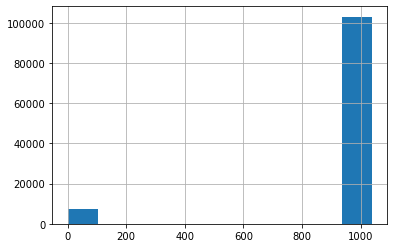

In [12]:
hist = cleanweather['Pressure'].hist()

We see the above outliers are beyond the possible range of air pressure measured in millibars so those readings may be using a different scale. We'll want to either set them to NA or rescale them to match the rest.  

(7180, 2)

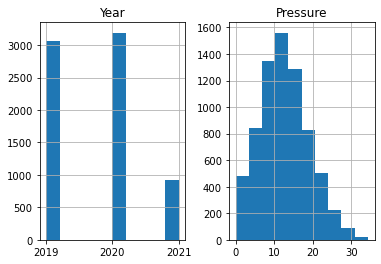

In [13]:
#Display chart of both pressure and year for the out of range values to see if a certain time period consistently used a different scale: 
df = cleanweather.loc[cleanweather.Pressure.lt(500), ['Year', 'Pressure']]
hist = df.hist()
df.shape

We see that all of the outlier pressure values are from the most recent couple of years. It should be "Mean station pressure for the day in millibars to tenths." but these can't be in millibars. 

(8374, 2)

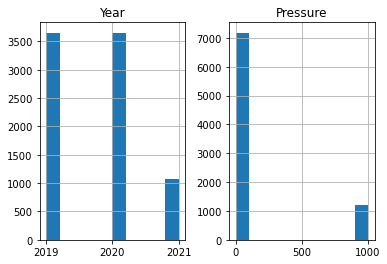

In [14]:
df = cleanweather.loc[cleanweather.Year.gt(2018), ['Year', 'Pressure']]
hist = df.hist()
df.shape

We see most of the data, even for recent years, is not in the outlier range. The bad data ranges from 0 to 30 but should always be near 1000. Checking the most recent [documentation](https://data.noaa.gov/dataset/dataset/global-surface-summary-of-the-day-gsod) confirms mb is still in use as the unit of measure. There is no obvious other scale they could be using on the outliers. We will set them to NA as we are unable to convert them. 

In [15]:
cleanweather.Pressure.loc[cleanweather.Pressure.lt(500)] = np.nan

/Users/bem/opt/anaconda3/envs/SB/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


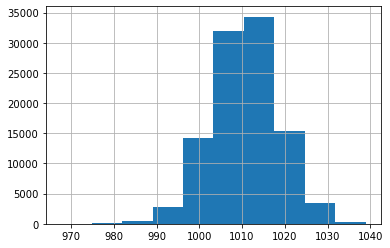

In [16]:
#confirm the above caveat didn't affect us.  
hist = cleanweather['Pressure'].hist()

Distribution is around 1000 just as expected. 

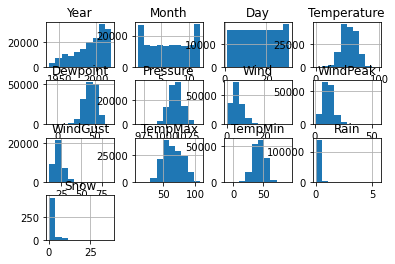

In [17]:
hist = cleanweather.hist()

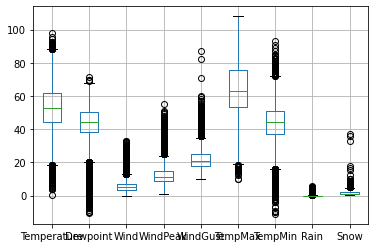

In [18]:
hist = cleanweather.drop(['Year', 'Month', 'Day', 'Pressure'], axis=1).boxplot()

The outliers we see now would seem to only represent extreme weather events, rather than errors. 

In [19]:
cleanweather.agg(['min', 'max'])

,Year,Month,Day,Temperature,Dewpoint,Pressure,Wind,WindPeak,WindGust,TempMax,TempMin,Rain,Snow
min,1936,1,1,0.1,-10.7,967.7,0.0,1.0,9.9,10.0,-11.0,0.00,0.4
max,2021,12,31,97.9,71.6,1038.9,33.1,55.0,87.0,108.0,93.2,5.51,37.4


We see that there are no longer large amounts of anomolies for any of the weather columns. All columns are seen to be within reasonable ranges expected on Earth. 

### Filling Empty Values <a name="FillingEmptyValues"></a>

Some NA fields should be treated differently than others. Let's do that as follows: 

Don't set to zero or mean. Leave or interpolate using time-adjacent values: 
- Temperature
- TempMax
- TempMin

Never set to zero. Set to mean or leave NA: 
- Dewpoint
- Pressure

These instruments often report NA instead of 0. Set to zero: 
- WindPeak
- WindGust
- Wind

Cumulative amounts. Never use adjacent or mean. Set to zero: 
- Rain
- Snow

No NAs present. Keys. 
- Station IDs
- Year
- Month
- Day

In [20]:
#use notes above to make column lists
tosettozero = ['WindPeak', 'WindGust', 'Wind', 'Rain', 'Snow']
tosettomean = ['Dewpoint', 'Pressure']
tointerpolate = ['Temperature', 'TempMax', 'TempMin']

In [21]:
cleanweather.isna().sum()

Year                0
Month               0
Day                 0
Temperature         0
Dewpoint         8128
Pressure        59956
Wind             5327
WindPeak         5630
WindGust       122991
TempMax            92
TempMin           169
Rain            18805
Snow           162406
dtype: int64

In [22]:
#We'll need a date field if we are to fillna with time-adjacent values: 
cleanweather['date'] = pd.to_datetime( cleanweather[['Year', 'Month', 'Day']] )
cleanweather = cleanweather.set_index(['date']).sort_index()
#Look at it
cleanweather[['Year', 'Month', 'Day']]

,Year,Month,Day
date,,,
1936-05-01,1936,5,1
1936-05-02,1936,5,2
1936-05-03,1936,5,3
1936-05-04,1936,5,4
1936-05-05,1936,5,5
...,...,...,...
2021-04-20,2021,4,20
2021-04-20,2021,4,20
2021-04-20,2021,4,20


In [23]:
filledweather = cleanweather
#filledweather[tointerpolate].fillna(method='ffill', inplace=True)
filledweather[tointerpolate].interpolate(method='nearest', inplace=True)
filledweather[tosettozero].fillna(0, inplace=True)
filledweather[tosettomean].fillna(value=filledweather[tosettomean].mean(), inplace=True)


<ipython-input-23-e859bb0c6943>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filledweather[tointerpolate].interpolate(method='nearest', inplace=True)
/Users/bem/opt/anaconda3/envs/SB/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/bem/opt/anaconda3/envs/SB/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [24]:
filledweather.isna().sum()

Year                0
Month               0
Day                 0
Temperature         0
Dewpoint         8128
Pressure        59956
Wind             5327
WindPeak         5630
WindGust       122991
TempMax            92
TempMin           169
Rain            18805
Snow           162406
dtype: int64

That didn't work. Try deeper copies: 

In [25]:
filledweather = cleanweather.copy()
#filledweather[tointerpolate].fillna(method='ffill', inplace=True)
filledweather.loc[:, tointerpolate].interpolate(method='nearest', inplace=True)
filledweather.loc[:, tosettozero].fillna(0, inplace=True)
filledweather.loc[:, tosettomean].fillna(value=filledweather[tosettomean].mean(), inplace=True)


In [26]:
filledweather.isna().sum()

Year                0
Month               0
Day                 0
Temperature         0
Dewpoint         8128
Pressure        59956
Wind             5327
WindPeak         5630
WindGust       122991
TempMax            92
TempMin           169
Rain            18805
Snow           162406
dtype: int64

Did not get the copy warning after changing to .loc() and .copy(), yet it still didn't fill the NAs. Let's try a third way: 

In [37]:
filledweather = cleanweather.copy()
#filledweather[tointerpolate].fillna(method='ffill', inplace=True)
filledweather[tointerpolate] = filledweather[tointerpolate].interpolate(method='nearest')
filledweather[tosettozero] = filledweather[tosettozero].fillna(0)
filledweather[tosettomean] = filledweather[tosettomean].fillna(value=filledweather[tosettomean].mean())

In [38]:
filledweather.isna().sum()

Year           0
Month          0
Day            0
Temperature    0
Dewpoint       0
Pressure       0
Wind           0
WindPeak       0
WindGust       0
TempMax        0
TempMin        0
Rain           0
Snow           0
dtype: int64

No more NA values present. Our current index is the date/time so we can drop the other date fields.

In [41]:
finalweather = filledweather.drop(['Year', 'Month', 'Day'], 1)

In [42]:
finalweather

,Temperature,Dewpoint,Pressure,Wind,WindPeak,WindGust,TempMax,TempMin,Rain,Snow
date,,,,,,,,,,
1936-05-01,57.6,46.400000,1010.653546,3.0,5.1,0.0,76.3,43.3,0.0,0.0
1936-05-02,61.5,54.100000,1010.653546,4.5,29.9,0.0,73.4,53.4,0.0,0.0
1936-05-03,61.8,54.600000,1010.653546,2.5,5.1,0.0,69.3,56.3,0.0,0.0
1936-05-04,56.6,51.800000,1010.653546,4.1,8.9,0.0,63.3,50.4,0.0,0.0
1936-05-05,52.1,46.000000,1010.653546,5.4,15.9,0.0,58.3,46.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-04-20,60.7,41.300000,1010.653546,4.3,8.0,0.0,71.1,54.0,0.0,0.0
2021-04-20,64.9,43.860209,999.900000,0.0,0.0,0.0,74.1,57.0,0.0,0.0
2021-04-20,63.0,32.000000,1010.653546,8.4,9.9,0.0,71.1,55.9,0.0,0.0


#### Exporting data <a name="Exportingdata"></a>

In [43]:
weatherdf.to_pickle("../data/interim/weather.pkl")

Work will continue in [Notebook3](cap2_NB03.ipynb) where we will clean the crop data. 

In [27]:
#verify files are < 100MB, due to a .ipynb size issue: 
!ls -lh

total 75192
-rw-r--r--@ 1 bem  staff    20M Apr 30 15:09 cap2_NB01.ipynb
-rw-r--r--@ 1 bem  staff    31K Apr 30 15:15 cap2_NB02.ipynb
-rw-r--r--@ 1 bem  staff    15K Apr 30 15:10 cap2_NB03.ipynb
-rw-r--r--  1 bem  staff   640K Apr 30 14:46 cropdf2profile.html
-rw-r--r--  1 bem  staff   1.3M Apr 30 14:46 cropdfprofile.html
-rw-r--r--  1 bem  staff    15M Apr 30 15:16 weatherdfprofile.html
